# @title Convert Era5 from netcdf to 

# Load ERA5 2021 June & July

In [1]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install xarray netCDF4 cartopy matplotlib


## Plot BC maps for July 1st

Copying gs://gencast/ERA5_2021_07/data_stream-oper_stepType-instant.nc...
/ [1 files][453.6 KiB/453.6 KiB]                                                
Operation completed over 1 objects/453.6 KiB.                                    
July Dataset info:
<xarray.Dataset> Size: 1MB
Dimensions:     (valid_time: 52, latitude: 49, longitude: 105)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 416B 2021-07-01 ... 2021-07-13T18...
  * latitude    (latitude) float64 392B 60.0 59.75 59.5 ... 48.5 48.25 48.0
  * longitude   (longitude) float64 840B -139.0 -138.8 -138.5 ... -113.2 -113.0
    expver      (valid_time) <U4 832B ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 1MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Ra

/var/tmp/ipykernel_2693/1035080736.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 0.95])


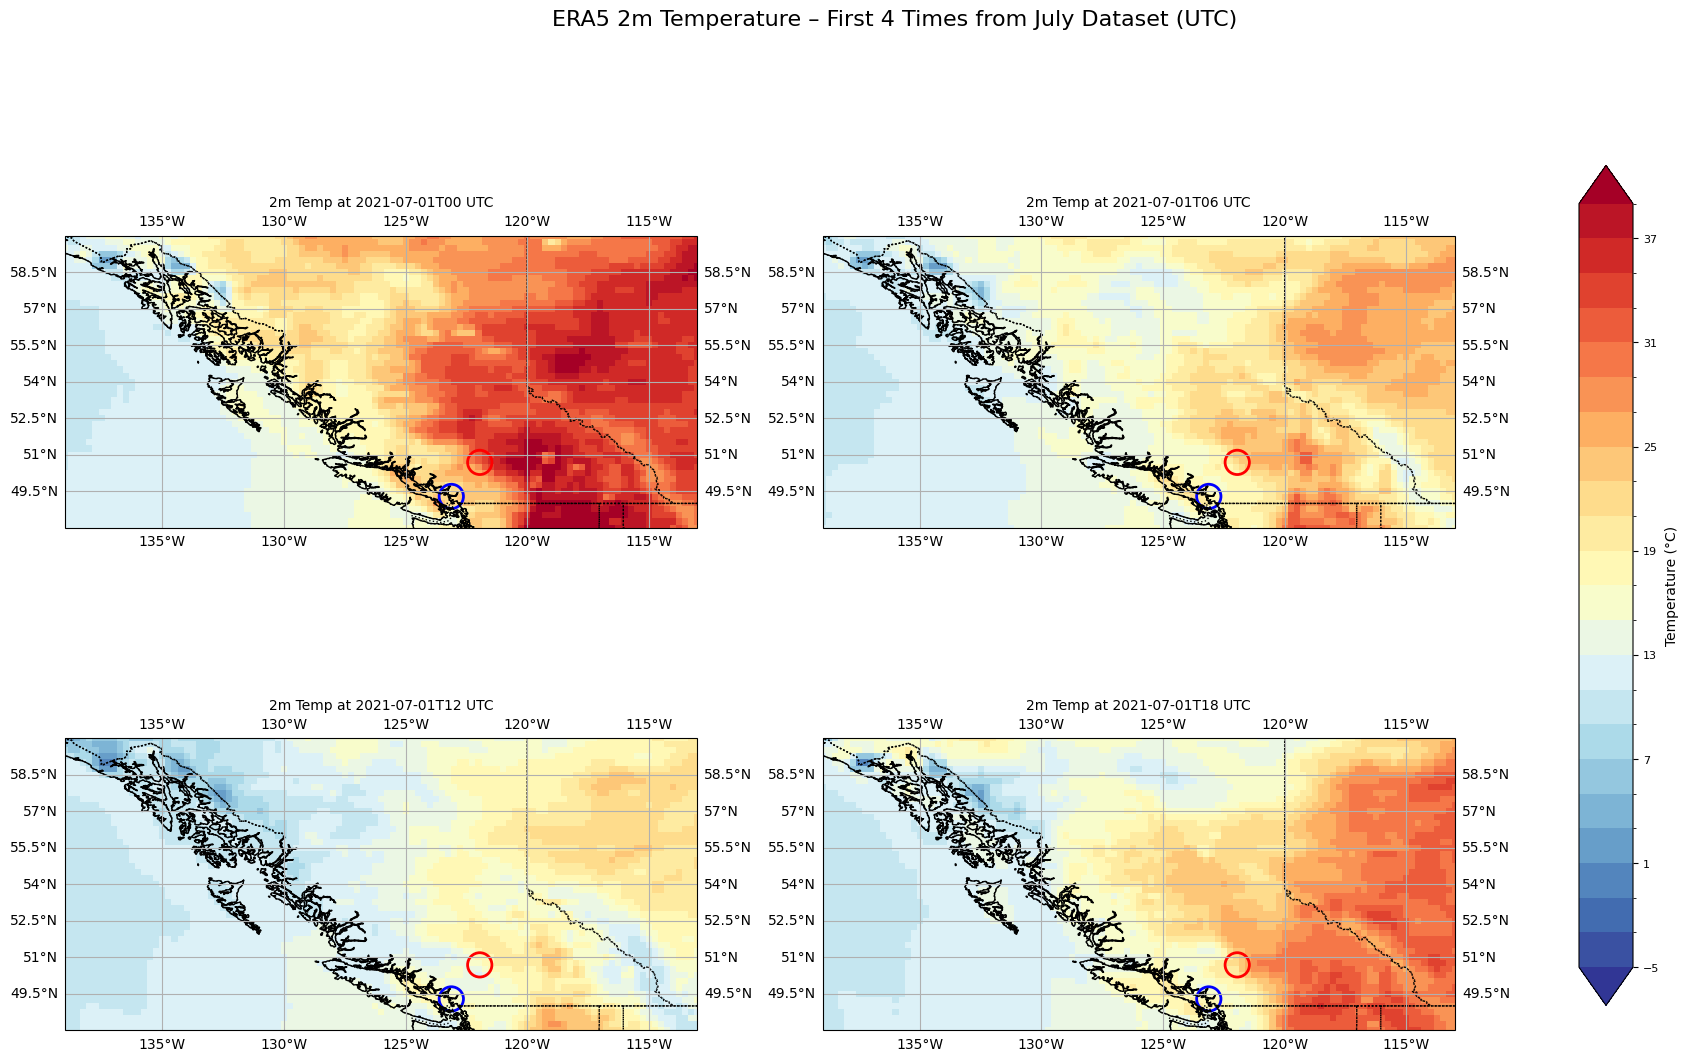


Summary Statistics for Selected Locations (First 4 Times):
                     Location  Mean (°C)   Min (°C)   Max (°C)  Std (°C)
0  Vancouver (49.28, -123.12)  18.905914  16.882477  22.755035  2.274924
1     Lytton (50.68, -121.95)  23.462067  16.898102  32.130035  5.490783


In [36]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.patches import Circle
import pandas as pd

# Download the July ERA5 data file from Google Cloud Storage
!gsutil cp gs://gencast/ERA5_2021_07/data_stream-oper_stepType-instant.nc /tmp/era5_july.nc

# Open the July dataset
ds_july = xr.open_dataset('/tmp/era5_july.nc', engine='netcdf4')
print("July Dataset info:")
print(ds_july)

# Select the first four time steps (assuming valid_time is the time coordinate)
ds_july_first4 = ds_july.isel(valid_time=slice(0, 4))

# Define coordinates for the two locations:
vancouver_coord = {'latitude': 49.28, 'longitude': -123.12}
lytton_coord   = {'latitude': 50.68, 'longitude': -121.95}

# Create a 2x2 grid plot for the four time steps.
fig, axes = plt.subplots(2, 2, figsize=(18, 12),
                         subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

# Set contour levels (here from -5°C to 40°C)
levels = np.arange(-5, 41, 2)

for ax, t in zip(axes, ds_july_first4.valid_time.values):
    # Select the time slice and convert from Kelvin to Celsius
    t2m_slice = ds_july_first4['t2m'].sel(valid_time=t, method='nearest') - 273.15
    
    # Plot the data on the map
    im = t2m_slice.plot(ax=ax,
                        transform=ccrs.PlateCarree(),
                        cmap='RdYlBu_r',
                        levels=levels,
                        extend='both',
                        add_colorbar=False)
    
    # Add map features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle=':')
    ax.set_extent([-139, -113, 48, 60], crs=ccrs.PlateCarree())
    ax.gridlines(draw_labels=True)
    ax.set_title(f"2m Temp at {np.datetime_as_string(t, unit='h')} UTC", fontsize=10)
    
    # Overlay circles for Vancouver and Lytton
    # Adjust radius (in degrees) as needed; here 0.5° is used as an example.
    vancouver_circle = Circle((vancouver_coord['longitude'], vancouver_coord['latitude']),
                                radius=0.5,
                                edgecolor='blue',
                                facecolor='none',
                                linewidth=2,
                                transform=ccrs.PlateCarree())
    lytton_circle = Circle((lytton_coord['longitude'], lytton_coord['latitude']),
                           radius=0.5,
                           edgecolor='red',
                           facecolor='none',
                           linewidth=2,
                           transform=ccrs.PlateCarree())
    ax.add_patch(vancouver_circle)
    ax.add_patch(lytton_circle)

# Adjust the subplots to leave space on the right for the colorbar
fig.subplots_adjust(right=0.85)

# Add a separate axis for the colorbar on the right
cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, label='Temperature (°C)')
cbar.ax.tick_params(labelsize=8)

plt.suptitle('ERA5 2m Temperature – First 4 Times from July Dataset (UTC)', fontsize=16)
plt.tight_layout(rect=[0, 0, 0.85, 0.95])
plt.show()

# ----------------------------------------------------
# Create a summary table of statistics for Vancouver and Lytton
# ----------------------------------------------------
# Extract temperature data (Kelvin converted to °C) at the two locations from the first four time steps
vancouver_temps = ds_july_first4['t2m'].sel(latitude=vancouver_coord['latitude'],
                                             longitude=vancouver_coord['longitude'],
                                             method='nearest') - 273.15
lytton_temps = ds_july_first4['t2m'].sel(latitude=lytton_coord['latitude'],
                                           longitude=lytton_coord['longitude'],
                                           method='nearest') - 273.15

# Compute summary statistics
summary_data = {
    "Location": ["Vancouver (49.28, -123.12)", "Lytton (50.68, -121.95)"],
    "Mean (°C)": [float(vancouver_temps.mean()), float(lytton_temps.mean())],
    "Min (°C)": [float(vancouver_temps.min()), float(lytton_temps.min())],
    "Max (°C)": [float(vancouver_temps.max()), float(lytton_temps.max())],
    "Std (°C)": [float(vancouver_temps.std()), float(lytton_temps.std())]
}

df_summary = pd.DataFrame(summary_data)
print("\nSummary Statistics for Selected Locations (First 4 Times):")
print(df_summary)


## Plot time-series for Vancouver and Lytton

Copying gs://gencast/ERA5_2021_06/data_stream-oper_stepType-instant.nc...
/ [1 files][225.5 KiB/225.5 KiB]                                                
Operation completed over 1 objects/225.5 KiB.                                    
Copying gs://gencast/ERA5_2021_07/data_stream-oper_stepType-instant.nc...
/ [1 files][453.6 KiB/453.6 KiB]                                                
Operation completed over 1 objects/453.6 KiB.                                    
June Dataset info:
<xarray.Dataset> Size: 496kB
Dimensions:     (valid_time: 24, latitude: 49, longitude: 105)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 192B 2021-06-25 ... 2021-06-30T18...
  * latitude    (latitude) float64 392B 60.0 59.75 59.5 ... 48.5 48.25 48.0
  * longitude   (longitude) float64 840B -139.0 -138.8 -138.5 ... -113.2 -113.0
    expver      (valid_time) <U4 384B ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 494kB ...
Attributes

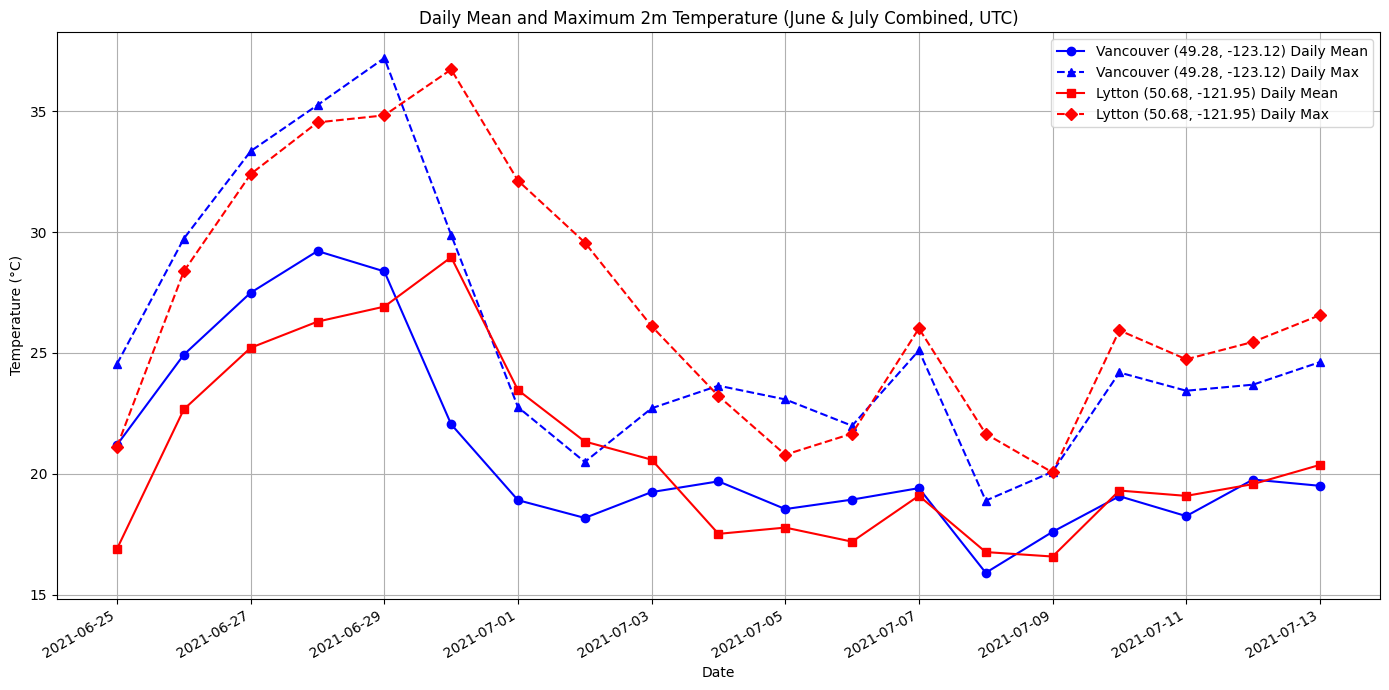

Vancouver time series (°C): [23.422272 20.36441  16.455719 24.546295 27.883453 22.836578 19.264313
 29.732819 33.350494 24.506256 21.02945  31.086334 35.257477 25.54361
 22.8732   33.19156  37.20279  26.451813 23.166412 26.673737 29.881012
 21.21109  16.881012 20.210358 22.755035 18.242584 16.882477 17.74356
 20.487701 17.393463 15.88736  18.916168 22.709625 18.619537 15.556549
 20.078033 23.644684 19.97696  14.844391 20.275055 23.07608  17.59732
 14.559967 18.918121 21.984772 18.630768 14.555084 20.547028 25.104645
 20.502838 13.82486  18.186432 18.887848 15.278961 13.555817 15.879059
 20.082184 16.843414 14.40152  19.056305 24.190582 19.391754 13.314362
 19.380524 23.435211 16.715485 13.689606 19.146637 23.686432 19.746735
 15.061432 20.54776  24.619293 18.391998 15.311188 19.67984 ]
Lytton time series (°C): [20.766022  15.561676  10.117828  21.126373  28.377594  21.613922
 14.992828  25.685944  32.401276  24.37735   14.334137  29.738678
 34.54068   25.307281  15.605621  29.728668  3

In [35]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Download both June and July ERA5 data files
!gsutil cp gs://gencast/ERA5_2021_06/data_stream-oper_stepType-instant.nc /tmp/era5_june.nc
!gsutil cp gs://gencast/ERA5_2021_07/data_stream-oper_stepType-instant.nc /tmp/era5_july.nc

# Open the datasets
ds_june = xr.open_dataset('/tmp/era5_june.nc', engine='netcdf4')
ds_july = xr.open_dataset('/tmp/era5_july.nc', engine='netcdf4')

print("June Dataset info:")
print(ds_june)
print("July Dataset info:")
print(ds_july)

# Concatenate the two datasets along the time (valid_time) dimension.
ds_combined = xr.concat([ds_june, ds_july], dim="valid_time")
print("\nCombined Dataset info:")
print(ds_combined)

# Define coordinates for the two locations:
# Vancouver: (latitude: 49.28, longitude: -123.12)
# Lytton:    (latitude: 50.68, longitude: -121.95)
vancouver_coord = {'latitude': 49.28, 'longitude': -123.12}
lytton_coord   = {'latitude': 50.68, 'longitude': -121.95}

# Extract the time series at these locations and convert from Kelvin to Celsius
vancouver_da = ds_combined['t2m'].sel(latitude=vancouver_coord['latitude'],
                                      longitude=vancouver_coord['longitude'],
                                      method='nearest') - 273.15
lytton_da   = ds_combined['t2m'].sel(latitude=lytton_coord['latitude'],
                                      longitude=lytton_coord['longitude'],
                                      method='nearest') - 273.15

# Convert the DataArrays to pandas Series using valid_time as the index
vancouver_series = pd.Series(vancouver_da.values, 
                             index=pd.to_datetime(vancouver_da.valid_time.values))
lytton_series = pd.Series(lytton_da.values, 
                           index=pd.to_datetime(lytton_da.valid_time.values))

# Compute daily averages and maximums by grouping by the date portion of the index
vancouver_daily_mean = vancouver_series.groupby(vancouver_series.index.date).mean()
vancouver_daily_max  = vancouver_series.groupby(vancouver_series.index.date).max()

lytton_daily_mean = lytton_series.groupby(lytton_series.index.date).mean()
lytton_daily_max  = lytton_series.groupby(lytton_series.index.date).max()

# Plot the daily mean and maximum temperatures with consistent colors per location
plt.figure(figsize=(14, 7))
# Vancouver in blue
plt.plot(vancouver_daily_mean.index, vancouver_daily_mean, color='blue', marker='o', linestyle='-', 
         label='Vancouver (49.28, -123.12) Daily Mean')
plt.plot(vancouver_daily_max.index, vancouver_daily_max, color='blue', marker='^', linestyle='--', 
         label='Vancouver (49.28, -123.12) Daily Max')
# Lytton in red
plt.plot(lytton_daily_mean.index, lytton_daily_mean, color='red', marker='s', linestyle='-', 
         label='Lytton (50.68, -121.95) Daily Mean')
plt.plot(lytton_daily_max.index, lytton_daily_max, color='red', marker='D', linestyle='--', 
         label='Lytton (50.68, -121.95) Daily Max')

plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Daily Mean and Maximum 2m Temperature (June & July Combined, UTC)')
plt.grid(True)
plt.legend()
plt.gcf().autofmt_xdate()  # Auto-format the x-axis dates for clarity
plt.tight_layout()
plt.show()

# Optional: Print the extracted time series values for verification
print("Vancouver time series (°C):", vancouver_series.values)
print("Lytton time series (°C):", lytton_series.values)

# Close the datasets when finished
ds_june.close()
ds_july.close()


# Get Queried WeatherNext dataset

In [6]:
!pip install dask gcsfs

In [7]:
!pip install --upgrade --force-reinstall --ignore-installed "pyarrow>=14.0.1"

  Using cached pyarrow-19.0.1-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
Using cached pyarrow-19.0.1-cp310-cp310-manylinux_2_28_x86_64.whl (42.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires cloudpickle~=2.2.1, but you have cloudpickle 3.1.1 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 19.0.1 which is incompatible.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 19.0.1 which is incompatible.


In [37]:
import subprocess

# List all CSV files in the folder using gsutil
cmd = ['gsutil', 'ls', 'gs://gencast/weathernext/weathernext_bc_heatwave_2021_avg/*.csv']
file_list = subprocess.check_output(cmd).decode('utf-8').strip().split('\n')
# If you only want the first two files:
file_list = file_list[:2]
print("Files to load:", file_list)


Files to load: ['gs://gencast/weathernext/weathernext_bc_heatwave_2021_avg/000000000000.csv', 'gs://gencast/weathernext/weathernext_bc_heatwave_2021_avg/000000000001.csv']


In [50]:
import pandas as pd

# mannually add column names (confirmed that no data loss)
column_names = [
    "init_time",
    "forecast_time",
    "geography_polygon_text",
    "geography_text",
    "avg_total_precipitation_12hr",
    "avg_100m_u_component_of_wind",
    "avg_100m_v_component_of_wind",
    "avg_10m_u_component_of_wind",
    "avg_10m_v_component_of_wind",
    "avg_2m_temperature",
    "avg_mean_sea_level_pressure",
    "avg_sea_surface_temperature",
]

df_small = pd.read_csv(
    'gs://gencast/weathernext/weathernext_bc_heatwave_2021_avg/000000000000.csv',
    names=column_names,   # Provide our own names
    header=None           # Tell pandas there's no header in the file
)
df_small.head()


,init_time,forecast_time,geography_polygon_text,geography_text,avg_total_precipitation_12hr,avg_100m_u_component_of_wind,avg_100m_v_component_of_wind,avg_10m_u_component_of_wind,avg_10m_v_component_of_wind,avg_2m_temperature,avg_mean_sea_level_pressure,avg_sea_surface_temperature
0,2021-06-11 00:00:00 UTC,2021-06-25 00:00:00 UTC,"POLYGON((-124.375 56.125, -124.375 56.375, -12...",POINT(-124.5 56.25),0.001902,1.374125,0.940806,0.778913,0.629433,290.115811,100918.925625,NaN
1,2021-06-11 00:00:00 UTC,2021-06-25 00:00:00 UTC,"POLYGON((-122.125 60.375, -122.125 60.625, -12...",POINT(-122.25 60.5),0.001651,1.774276,-0.006846,1.169389,0.036483,291.546456,100663.083437,NaN
2,2021-06-11 00:00:00 UTC,2021-06-25 00:00:00 UTC,"POLYGON((-121.625 48.875, -121.625 49.125, -12...",POINT(-121.75 49),0.002933,2.890096,1.319075,1.839132,0.798582,289.277111,101452.883750,NaN
3,2021-06-11 00:00:00 UTC,2021-06-25 00:00:00 UTC,"POLYGON((-137.875 48.625, -137.875 48.875, -13...",POINT(-138 48.75),0.000860,5.562886,-0.109651,4.313305,-0.019562,284.580817,102055.331875,284.351389
4,2021-06-11 00:00:00 UTC,2021-06-25 00:00:00 UTC,"POLYGON((-128.875 54.375, -128.875 54.625, -12...",POINT(-129 54.5),0.004525,0.827467,0.435435,0.486116,0.186816,286.464780,101436.475156,NaN


## Load all CSV results from BigQuery

In [49]:
import subprocess
import pandas as pd
import geopandas as gpd
from shapely import wkt

# ---------------------------------------
# 1) CONFIGURATION
# ---------------------------------------
load_all = True  
# ---------------------------------------
# 2) LIST & LOAD CSV FILES
# ---------------------------------------
cmd = ['gsutil', 'ls', 'gs://gencast/weathernext/weathernext_bc_heatwave_2021_avg/*.csv']
file_list = subprocess.check_output(cmd).decode('utf-8').strip().split('\n')

# Optionally limit to just the first N files if load_all is False
if not load_all:
    file_list = file_list[:2]

print("Files to load:", file_list)

df_list = []
for f in file_list:
    df_temp = pd.read_csv(f, names=column_names, header=None)
    df_list.append(df_temp)

# Concatenate into one DataFrame
df_all = pd.concat(df_list, ignore_index=True)

# ---------------------------------------
# 3) CONVERT TO GEODATAFRAME
# ---------------------------------------
# Convert times to datetime
df_all['init_time'] = pd.to_datetime(df_all['init_time'], errors='coerce')
df_all['forecast_time'] = pd.to_datetime(df_all['forecast_time'], errors='coerce')

# Convert WKT polygons to geometry
df_all['geometry'] = df_all['geography_polygon_text'].apply(wkt.loads)

# Create a GeoDataFrame in EPSG:4326 (lat/lon)
gdf_wn = gpd.GeoDataFrame(df_all, geometry='geometry', crs='EPSG:4326')

# ---------------------------------------
# 4) QUICK INSPECTION
# ---------------------------------------
print("\nCombined GeoDataFrame:")
print(gdf_wn.head())
print("\nEarliest forecast_time:", gdf_wn['forecast_time'].min())
print("Latest forecast_time:", gdf_wn['forecast_time'].max())


Files to load: ['gs://gencast/weathernext/weathernext_bc_heatwave_2021_avg/000000000000.csv', 'gs://gencast/weathernext/weathernext_bc_heatwave_2021_avg/000000000001.csv', 'gs://gencast/weathernext/weathernext_bc_heatwave_2021_avg/000000000002.csv', 'gs://gencast/weathernext/weathernext_bc_heatwave_2021_avg/000000000003.csv']

Combined GeoDataFrame:
                  init_time             forecast_time  \
0 2021-06-11 00:00:00+00:00 2021-06-25 00:00:00+00:00   
1 2021-06-11 00:00:00+00:00 2021-06-25 00:00:00+00:00   
2 2021-06-11 00:00:00+00:00 2021-06-25 00:00:00+00:00   
3 2021-06-11 00:00:00+00:00 2021-06-25 00:00:00+00:00   
4 2021-06-11 00:00:00+00:00 2021-06-25 00:00:00+00:00   

                              geography_polygon_text       geography_text  \
0  POLYGON((-124.375 56.125, -124.375 56.375, -12...  POINT(-124.5 56.25)   
1  POLYGON((-122.125 60.375, -122.125 60.625, -12...  POINT(-122.25 60.5)   
2  POLYGON((-121.625 48.875, -121.625 49.125, -12...    POINT(-121.75 49) 

## Plot BC maps for July 1st

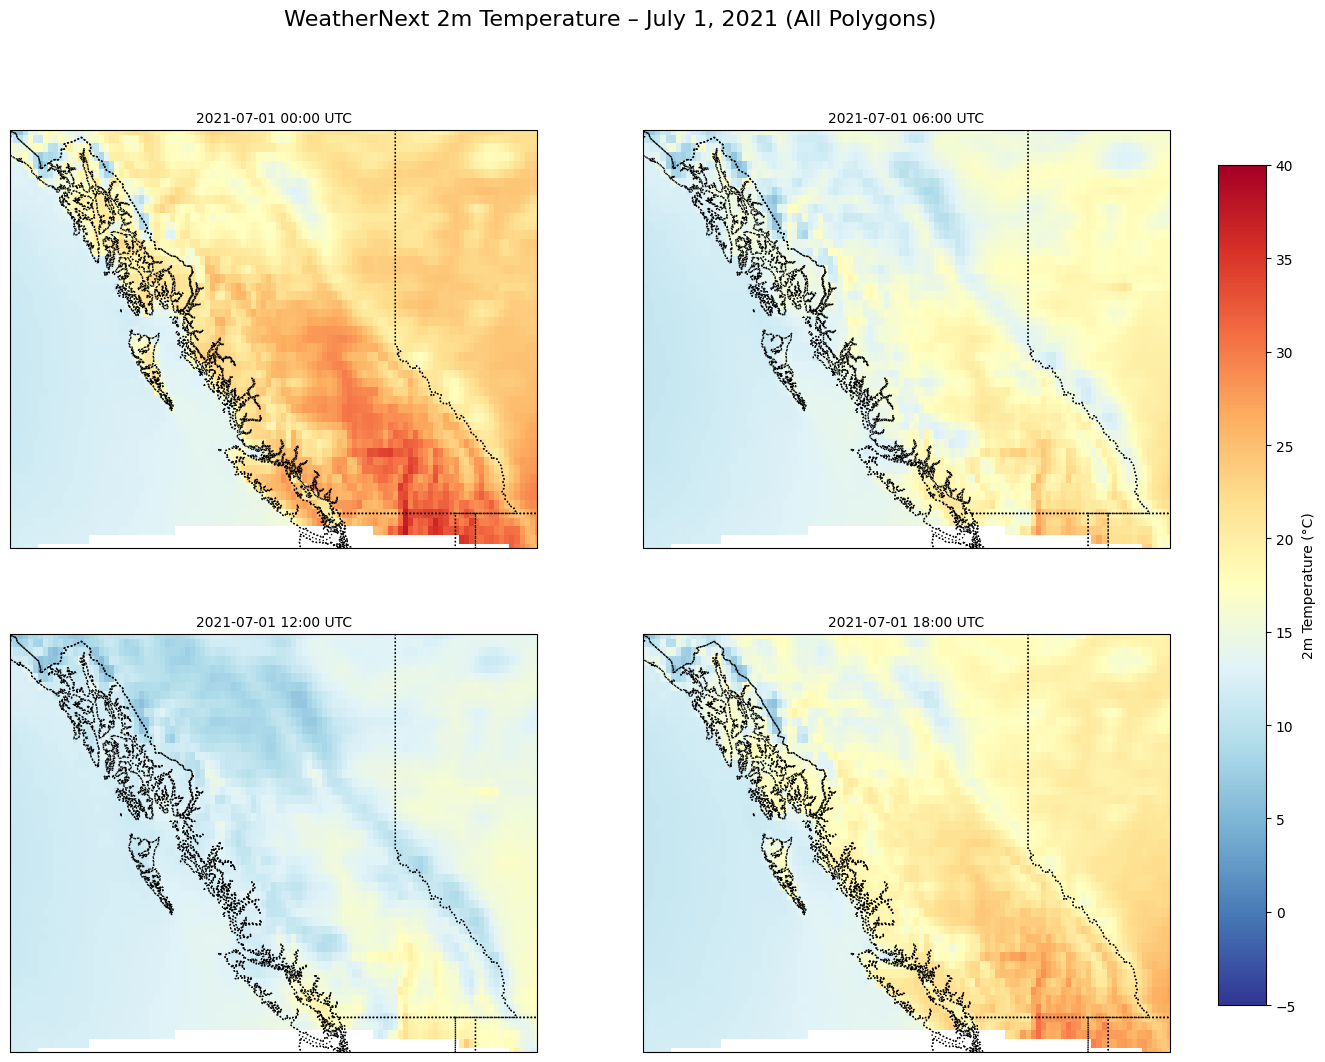

In [54]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import pandas as pd

# --- Filter for July 1, 2021 ---
start_time = pd.to_datetime("2021-07-01 00:00:00+00:00")
end_time   = pd.to_datetime("2021-07-02 00:00:00+00:00")
july1 = gdf_wn[(gdf_wn['forecast_time'] >= start_time) & (gdf_wn['forecast_time'] < end_time)].copy()

# --- Convert 2m temperature from Kelvin to Celsius ---
july1['avg_2m_temperature_c'] = july1['avg_2m_temperature'] - 273.15

# --- Define target times ---
target_times = pd.to_datetime([
    "2021-07-01 00:00:00+00:00",
    "2021-07-01 06:00:00+00:00",
    "2021-07-01 12:00:00+00:00",
    "2021-07-01 18:00:00+00:00"
])

# --- Set up 2x2 grid of maps ---
fig, axs = plt.subplots(2, 2, figsize=(16, 12), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()

# Use a consistent temperature scale: from -5°C to 40°C
vmin, vmax = -5, 40

for ax, t in zip(axs, target_times):
    subset = july1[july1['forecast_time'] == t]
    if subset.empty:
        ax.text(0.5, 0.5, f"No data for {t}", transform=ax.transAxes, ha='center')
    else:
        subset.plot(ax=ax, column='avg_2m_temperature_c', cmap='RdYlBu_r',
                    vmin=vmin, vmax=vmax, edgecolor='none')
    for feat in [cfeature.COASTLINE, cfeature.BORDERS, cfeature.STATES]:
        ax.add_feature(feat, linestyle=':')
    ax.set_extent([-139, -113, 48, 60], crs=ccrs.PlateCarree())
    ax.set_title(t.strftime('%Y-%m-%d %H:%M UTC'), fontsize=10)

# Adjust subplots to leave space on the right for the colorbar
fig.subplots_adjust(right=0.85)

# --- Shared colorbar ---
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = mpl.cm.ScalarMappable(norm=norm, cmap='RdYlBu_r')
sm._A = []
cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax, label="2m Temperature (°C)")
cbar.ax.tick_params(labelsize=10)

plt.suptitle("WeatherNext 2m Temperature – July 1, 2021 (All Polygons)", fontsize=16)
plt.show()


## Plot time-series for Vancouver and Lytton

/var/tmp/ipykernel_2693/2298053269.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  vancouver_data = wn_period[wn_period['geometry'].distance(vancouver_point) < buffer_radius]
/var/tmp/ipykernel_2693/2298053269.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lytton_data   = wn_period[wn_period['geometry'].distance(lytton_point) < buffer_radius]
/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

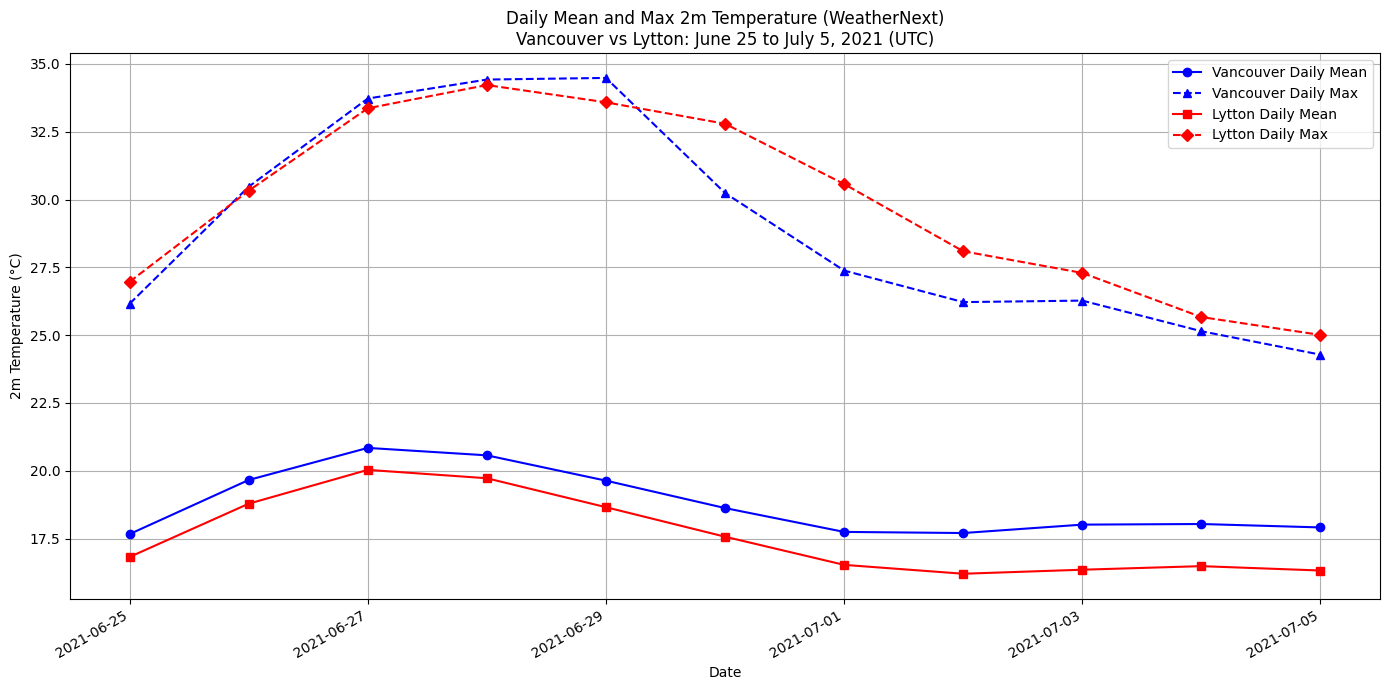

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import shapely.geometry as geom

# --- 1. Filter for June 25 to July 5 forecast times ---
start_time = pd.to_datetime("2021-06-25 00:00:00+00:00")
end_time   = pd.to_datetime("2021-07-05 23:59:59+00:00")
wn_period = gdf_wn[(gdf_wn['forecast_time'] >= start_time) & (gdf_wn['forecast_time'] <= end_time)].copy()

# --- 2. Convert temperature from Kelvin to Celsius ---
wn_period['avg_2m_temperature_c'] = wn_period['avg_2m_temperature'] - 273.15

# --- 3. Define locations and select nearby polygons ---
# Define points for Vancouver and Lytton
vancouver_point = geom.Point(-123.12, 49.28)
lytton_point   = geom.Point(-121.95, 50.68)
buffer_radius = 0.1  # degrees; adjust as needed

# Filter polygons that lie within the buffer of each point
vancouver_data = wn_period[wn_period['geometry'].distance(vancouver_point) < buffer_radius]
lytton_data   = wn_period[wn_period['geometry'].distance(lytton_point) < buffer_radius]

# --- 4. Compute daily mean and maximum temperatures ---
# Create a new column for the forecast date
vancouver_data['forecast_date'] = vancouver_data['forecast_time'].dt.date
lytton_data['forecast_date'] = lytton_data['forecast_time'].dt.date

vancouver_daily_mean = vancouver_data.groupby('forecast_date')['avg_2m_temperature_c'].mean()
vancouver_daily_max  = vancouver_data.groupby('forecast_date')['avg_2m_temperature_c'].max()

lytton_daily_mean = lytton_data.groupby('forecast_date')['avg_2m_temperature_c'].mean()
lytton_daily_max  = lytton_data.groupby('forecast_date')['avg_2m_temperature_c'].max()

# --- 5. Plot the time series ---
plt.figure(figsize=(14, 7))
# Vancouver in blue
plt.plot(vancouver_daily_mean.index, vancouver_daily_mean, marker='o', linestyle='-', color='blue', label='Vancouver Daily Mean')
plt.plot(vancouver_daily_max.index, vancouver_daily_max, marker='^', linestyle='--', color='blue', label='Vancouver Daily Max')
# Lytton in red
plt.plot(lytton_daily_mean.index, lytton_daily_mean, marker='s', linestyle='-', color='red', label='Lytton Daily Mean')
plt.plot(lytton_daily_max.index, lytton_daily_max, marker='D', linestyle='--', color='red', label='Lytton Daily Max')

plt.xlabel("Date")
plt.ylabel("2m Temperature (°C)")
plt.title("Daily Mean and Max 2m Temperature (WeatherNext)\nVancouver vs Lytton: June 25 to July 5, 2021 (UTC)")
plt.legend()
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()


Vancouver and Lytton's time-series temperature sequence

In [68]:
import pandas as pd
import shapely.geometry as geom

# --- Filter for forecast times from June 25 to July 5 ---
start_time = pd.to_datetime("2021-06-25 00:00:00+00:00")
end_time   = pd.to_datetime("2021-07-05 23:59:59+00:00")
wn_period = gdf_wn[(gdf_wn['forecast_time'] >= start_time) & (gdf_wn['forecast_time'] <= end_time)].copy()

# --- Convert temperature from Kelvin to Celsius ---
wn_period['temp_c'] = wn_period['avg_2m_temperature'] - 273.15

# --- Define Vancouver and Lytton points ---
vancouver_point = geom.Point(-123.12, 49.28)
lytton_point   = geom.Point(-121.95, 50.68)
buffer_radius  = 0.1  # in degrees; adjust if needed

# --- Select polygons within the buffer around each location ---
vancouver_data = wn_period[wn_period['geometry'].distance(vancouver_point) < buffer_radius]
lytton_data   = wn_period[wn_period['geometry'].distance(lytton_point) < buffer_radius]

# --- Compute a temperature sequence by averaging values at each forecast time ---
vancouver_series = vancouver_data.groupby('forecast_time')['temp_c'].mean().sort_index()
lytton_series   = lytton_data.groupby('forecast_time')['temp_c'].mean().sort_index()

print("Vancouver time series (°C):", vancouver_series.values)
print("Lytton time series (°C):", lytton_series.values)


/var/tmp/ipykernel_2693/837652065.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  vancouver_data = wn_period[wn_period['geometry'].distance(vancouver_point) < buffer_radius]
/var/tmp/ipykernel_2693/837652065.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lytton_data   = wn_period[wn_period['geometry'].distance(lytton_point) < buffer_radius]


Vancouver time series (°C): [20.24040783 16.13337598 14.2309522  20.05415089 22.6561687  17.9126015
 15.73148539 22.27516822 24.76469088 19.14275501 16.81771552 22.52015116
 24.86968785 19.13826634 16.64038844 21.44702524 23.90319966 18.39137465
 16.06586344 19.96413016 22.66943871 17.50822469 15.34683253 18.72956813
 21.32765938 16.44779437 14.68401791 18.29386398 20.96553855 16.3463424
 14.62497402 18.6403717  21.20013066 16.58316559 14.88528542 19.09358566
 20.94783371 17.01400531 15.00199188 18.71019871 21.01524556 16.64882192
 15.100186   17.95572823]
Lytton time series (°C): [21.3283919  14.74083672 10.77476149 20.43936423 23.87823456 16.54946615
 12.47384194 22.09535373 25.74995206 17.69505127 13.63065005 22.86700995
 25.68114217 17.47111614 13.57811609 21.93303886 24.49081152 16.47493198
 12.74138881 20.65788854 23.36702013 15.43385303 11.8461617  19.32260193
 22.02130726 14.37935307 11.00961612 18.37638159 21.08014665 14.28640201
 10.6237278  18.45100134 21.25949929 14.2435862

# Analyze discrepancies between WeatherNext and ERA5

## t test

In [70]:
wn_vancouver_series = vancouver_series 
wn_lytton_series = lytton_series        

In [71]:
era5_vancouver_series = pd.Series(vancouver_da.values, 
    index=pd.to_datetime(vancouver_da.valid_time.values))
era5_lytton_series = pd.Series(lytton_da.values, 
    index=pd.to_datetime(lytton_da.valid_time.values))

In [72]:
import pandas as pd
from scipy.stats import ttest_rel

# Convert time bounds to tz-naive
start_time = pd.to_datetime("2021-06-25 00:00:00+00:00").tz_localize(None)
end_time   = pd.to_datetime("2021-07-05 23:59:59+00:00").tz_localize(None)

# --- Subset ERA5 series to the overlapping period ---
era5_vancouver_subset = era5_vancouver_series[
    (era5_vancouver_series.index >= start_time) & 
    (era5_vancouver_series.index <= end_time)
]
era5_lytton_subset = era5_lytton_series[
    (era5_lytton_series.index >= start_time) & 
    (era5_lytton_series.index <= end_time)
]

# --- For WeatherNext, ensure the index is also tz-naive ---
wn_vancouver_series = wn_vancouver_series.copy()
wn_lytton_series = wn_lytton_series.copy()
wn_vancouver_series.index = wn_vancouver_series.index.tz_localize(None)
wn_lytton_series.index = wn_lytton_series.index.tz_localize(None)

# --- Align the two data sources on common forecast times ---
common_times_v = era5_vancouver_subset.index.intersection(wn_vancouver_series.index)
common_times_l = era5_lytton_subset.index.intersection(wn_lytton_series.index)

era5_vancouver_common = era5_vancouver_subset.loc[common_times_v]
wn_vancouver_common   = wn_vancouver_series.loc[common_times_v]

era5_lytton_common = era5_lytton_subset.loc[common_times_l]
wn_lytton_common   = wn_lytton_series.loc[common_times_l]

# --- Perform paired t-tests ---
t_stat_v, p_val_v = ttest_rel(era5_vancouver_common.values, wn_vancouver_common.values)
t_stat_l, p_val_l = ttest_rel(era5_lytton_common.values, wn_lytton_common.values)

print("Vancouver T-test: t-statistic = {:.3f}, p-value = {:.3f}".format(t_stat_v, p_val_v))
print("Lytton T-test:   t-statistic = {:.3f}, p-value = {:.3f}".format(t_stat_l, p_val_l))


Vancouver T-test: t-statistic = 7.450, p-value = 0.000
Lytton T-test:   t-statistic = 8.736, p-value = 0.000


## Discrepancy maps

In [ ]:
import math
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import pandas as pd
from shapely import wkt

# --- Helper: extract ERA5 temperature at a given location and time ---
def get_era5_temp(row):
    pt = row['location']  # using point from geography_text
    lon, lat = pt.x, pt.y
    time = pd.to_datetime(row['forecast_time']).tz_localize(None)
    temp_K = ds_combined['t2m'].sel(latitude=lat, longitude=lon, valid_time=time, method='nearest').values.item()
    return temp_K - 273.15

# --- 1. Filter WeatherNext Data for July 1, 2021 only ---
wn_july1 = gdf_wn[gdf_wn['forecast_time'].dt.date == pd.to_datetime("2021-07-01").date()].copy()

# Use geography_text as the point location
wn_july1['location'] = wn_july1['geography_text'].apply(wkt.loads)

# Convert WeatherNext temperature from Kelvin to Celsius (if not already done)
wn_july1['temp_c'] = wn_july1['avg_2m_temperature'] - 273.15

# --- 2. Compute ERA5 temperature and discrepancy ---
wn_july1['era5_temp_c'] = wn_july1.apply(get_era5_temp, axis=1)
wn_july1['discrepancy'] = wn_july1['temp_c'] - wn_july1['era5_temp_c']

# --- 3. Group by forecast time and sample (if too many points) ---
unique_times = sorted(wn_july1['forecast_time'].dropna().unique())
print("Number of forecast times on July 1:", len(unique_times))

def sample_group(df, nmax=500):
    return df if len(df) <= nmax else df.sample(n=nmax, random_state=0)

groups = {t: sample_group(wn_july1[wn_july1['forecast_time'] == t]) for t in unique_times}

# --- 4. Plot discrepancy maps ---
# Define grid: use 7 columns (or fewer if less times) and compute rows accordingly
n = len(unique_times)
ncols = min(n, 7)
nrows = math.ceil(n / ncols)
vmin, vmax = -5, 40  # discrepancy scale in °C

fig, axs = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows),
                         subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()

for ax, t in zip(axs, unique_times):
    group = groups[t]
    group.plot(ax=ax, column='discrepancy', cmap='RdYlBu_r', vmin=vmin, vmax=vmax, edgecolor='none')
    for feat in [cfeature.COASTLINE, cfeature.BORDERS, cfeature.STATES]:
        ax.add_feature(feat, linestyle=':')
    ax.set_extent([-139, -113, 48, 60], crs=ccrs.PlateCarree())
    ax.set_title(pd.to_datetime(t).strftime('%H:%M UTC'), fontsize=8)

# Remove extra axes if any
for ax in axs[len(unique_times):]:
    ax.remove()

# Shared colorbar to the right
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = mpl.cm.ScalarMappable(norm=norm, cmap='RdYlBu_r')
sm._A = []
fig.subplots_adjust(right=0.9, wspace=0.3, hspace=0.5)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax, label="Discrepancy (°C)\n(WeatherNext - ERA5)")
cbar.ax.tick_params(labelsize=8)

plt.suptitle("Temperature Discrepancy Maps (WeatherNext minus ERA5)\nJuly 1, 2021", fontsize=16)
plt.show()


## Regress WeatherNext to ERA5

Limit range to Vancouver & Lytton areas because the dataset is huge

In [ ]:
import pandas as pd
from shapely import wkt
from shapely.geometry import Point
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# --- Use geography_text as the point location ---
# Create a new column 'location' by converting the geography_text (WKT) to geometry
gdf_wn['location'] = gdf_wn['geography_text'].apply(wkt.loads)

# Function to extract ERA5 temperature at a given location and forecast time
def get_era5_temp(row):
    # Use the location from the geography_text column (a Point)
    pt = row['location']
    lon, lat = pt.x, pt.y
    # Get forecast time (make tz-naive)
    time = pd.to_datetime(row['forecast_time']).tz_localize(None)
    # Extract ERA5 2m temperature using nearest neighbor (in Kelvin) and convert to Celsius
    temp_K = ds_combined['t2m'].sel(latitude=lat, longitude=lon, valid_time=time, method='nearest').values.item()
    return temp_K - 273.15

# Create a new column with ERA5 observed temperatures (in °C)
gdf_wn['era5_temp_c'] = gdf_wn.apply(get_era5_temp, axis=1)

# --- Limit regression to data near Vancouver and Lytton ---
vancouver_point = Point(-123.12, 49.28)
lytton_point   = Point(-121.95, 50.68)
buffer_radius  = 0.1  # degrees

subset = gdf_wn[
    (gdf_wn['location'].distance(vancouver_point) < buffer_radius) |
    (gdf_wn['location'].distance(lytton_point) < buffer_radius)
].copy()

print("Number of records in subset:", len(subset))

# --- Regression Setup ---
# Dependent Variable (Y): WeatherNext predicted temperature (assumed in column 'temp_c')
# Independent Variable (X): ERA5 observed temperature (in °C)
X = subset['era5_temp_c'].values.reshape(-1, 1)
Y = subset['temp_c'].values  # WeatherNext predicted temperature in Celsius

# Fit the linear regression model
model = LinearRegression()
model.fit(X, Y)
Y_pred = model.predict(X)

# Calculate R² and RMSE
R2 = model.score(X, Y)
RMSE = np.sqrt(mean_squared_error(Y, Y_pred))

print("Regression Results:")
print("Slope: {:.3f}".format(model.coef_[0]))
print("Intercept: {:.3f}".format(model.intercept_))
print("R²: {:.3f}".format(R2))
print("RMSE: {:.3f} °C".format(RMSE))
